In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw, ImageOps
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)
print(tf.config.list_physical_devices('GPU'))
from platform import python_version
print('Python', python_version())

np.random.seed(9)
tf.random.set_seed(42)

Using TensorFlow version 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Python 3.9.7


### Process Objects and Textures

(112, 96, 4)


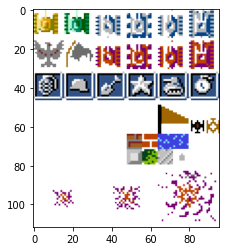

In [2]:
sprites = plt.imread('sprites.gif')
print(sprites.shape)
plt.imshow(sprites)

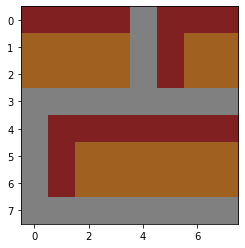

In [3]:
bs = 8
brick = sprites[bs*8:bs*9,bs*6:bs*7]
plt.imshow(brick)

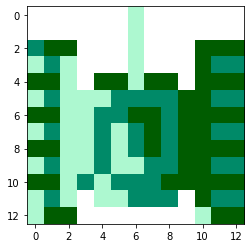

In [4]:
tank = sprites[:bs*2-3,bs*2:bs*4-3]
plt.imshow(tank)

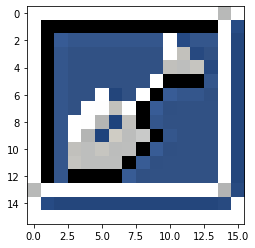

In [5]:
objects = {
    'tanks': [Image.fromarray(sprites[:bs*2-3, bs*2*i:bs*2*i+bs*2-3]) for i in range(2)],
    'enemies': [Image.fromarray(sprites[:bs*2-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
             #+ [Image.fromarray(sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
    'boosted_enemies': [Image.fromarray(sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
    'base': [sprites[bs*2:bs*4-2,bs*2*i:bs*2*i+bs*2] for i in range(2)],
    'bonuses': [sprites[bs*4:bs*6,bs*2*i:bs*2*i+bs*2] for i in range(6)],
}
textures = {
    'brick': Image.fromarray(sprites[bs*8:bs*9,bs*6:bs*7]),
    'water': Image.fromarray(sprites[bs*8:bs*9,bs*8:bs*9]),
    'steel': Image.fromarray(sprites[bs*9:bs*10,bs*6:bs*7]),
    'bush': Image.fromarray(sprites[bs*9:bs*10,bs*7:bs*8]),
    'ice': Image.fromarray(sprites[bs*9:bs*10,bs*8:bs*9]),
}
other = {
    'bullet': [],
    'explodions': [],
    'effects':[],
}

plt.imshow(objects['bonuses'][2])
#objects['bonuses'][2]

### Map Generation

In [6]:
n_maps = 35
ms = 128
maps = np.empty((n_maps,26), dtype='<U26')

for i in range(n_maps):
    with open(f'levels/{i+1}', "r") as f:
        data = f.read().split("\n")
        maps[i, :] = np.array(data)

print(maps.shape)
maps[0]

(35, 26)


array(['..........................', '..........................',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##@@##..##..##..', '..##..##..##@@##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..........##..##..........',
       '..........##..##..........', '##..####..........####..##',
       '@@..####..........####..@@', '..........##..##..........',
       '..........######..........', '..##..##..######..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..##..##...####...##..##..',
       '...........#..#...........', '...........#..#...........'],
      dtype='<U26')

In [7]:
with open(f'levels/test', "r") as f:
    data = f.read().split("\n")
    test_map = np.array(data)

In [8]:
def build_city(show_free_space=False):
    data = maps[np.random.randint(n_maps)]
    ts = 2*bs-2

    city = Image.new('RGBA', (ms, ms))
    bushes = Image.new('RGBA', (ms, ms))

    free_space = np.ones((ms, ms))
    free_space[-ts:,:] = 0
    free_space[:,-ts:] = 0
    
    def block_space(c1,c2):
        free_space[np.clip(c1-ts, 0, ms):c1+bs, np.clip(c2-ts, 0, ms):c2+bs] = 0
    
    #textures
    for i, row in enumerate(data):
        for j, c in enumerate(row):
            if bs*(i+1) > ms or bs*(j+1) > ms:
                break
                

            if c == '#':
                tx = textures['brick']
                block_space(bs*i,bs*j)
            elif c == '@':
                tx = textures['steel']
                block_space(bs*i,bs*j)
            elif c == '~':
                tx = textures['water']
                block_space(bs*i,bs*j)
            elif c == '-':
                tx = textures['ice']
            elif c == '%':
                tx = textures['bush']
                bushes.paste(tx, (bs*j, bs*i), tx)
                continue
            else:
                continue

            city.paste(tx, (bs*j, bs*i), tx)
            
    
    #tank
    class_id = np.random.randint(2)
    
    if show_free_space:
        plt.imshow(free_space)
        plt.show()
    
    free_coords = np.array(np.where(free_space == 1)).T
    (c1, c2) = free_coords[np.random.randint(free_coords.shape[0])]
    
    
    if class_id == 0:
        obj = objects['tanks'][np.random.randint(2)]
    else:
        obj = objects['enemies'][np.random.randint(4)]
    
    obj = obj.rotate(90 * np.random.randint(4))
    
    city.paste(obj, (c2, c1), obj)
    city.paste(bushes, (0,0), bushes)
    
    return np.array(city)[:,:,:3], class_id, (c1/ms, c2/ms)

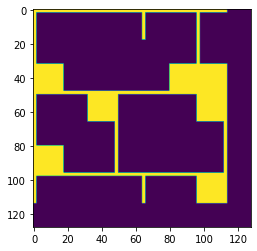

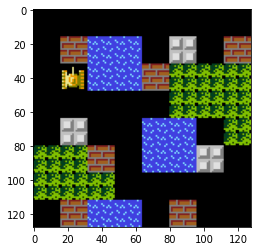

In [9]:
city, class_id, tank_coords = build_city(True)
plt.imshow(city)

In [10]:
free_space = np.ones((4, 4))
free_space[-1,:] = 0
free_space[:,-1] = 0
free_space

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [0., 0., 0., 0.]])

$208 \times 208$

In [11]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    row, col = gt_coords
    
    if norm:
        image *= 255.
        image = image.astype('uint8')
        
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    
    row *= ms
    col *= ms
    draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#4CFF52', width=3) #4CFF52
    
    
    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= ms
        col *= ms
        draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#FF229A', width=3) #FF229A
        
    return image

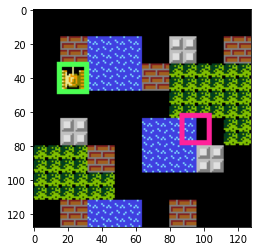

In [12]:
image = plot_bounding_box(city, tank_coords, (0.5, 0.7))
plt.imshow(image)

In [13]:
def data_generator(batch_size=64):
    #print('batch_size', batch_size)
    while True:
        x_batch = np.zeros((batch_size, ms, ms, 3))
        y_batch = np.zeros((batch_size, 2))
        bbox_batch = np.zeros((batch_size, 2))
        
        for i in range(0, batch_size):
            image, class_id, coords = build_city()

            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.
            bbox_batch[i] = np.array(coords)
            
        #print('\n New gen', batch_size)
        
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch} # inputs, outputs

Text(0.5, 1.0, '1')

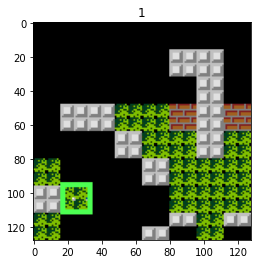

In [14]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(class_id)

In [15]:
input_ = Input(shape=(ms, ms, 3), name='image')

x = input_

for i in range(0, 5):
    #n_filters = 2**(1 + i)
    n_filters = 2**(2 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
    
class_out = Dense(2, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 4)  112         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### Metric: IoU

In [16]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
            
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
            
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)
        
        # elements with intersection
        mask = tf.cast(tf.math.logical_and(tf.math.less(i_x1, i_x2), tf.math.less(i_y1, i_y2)), tf.float32)
        
        i_area = tf.math.multiply(get_area(i_x1, i_y1, i_x2, i_y2), mask)
        
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
        
        iou = tf.math.divide(i_area, u_area)
        
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))              # ???
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Task 8: Compile the Model

In [17]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    },
    run_eagerly=True
)

## Task 9: Custom Callback: Model Testing

In [18]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    
    pred_class = np.argmax(pred_y[0])
    gt_class = np.argmax(y[0])
    
    image = x[0]
    
    gt = 'tank' if gt_class == 0 else 'enemy'
    pred_class_name = 'tank' if pred_class == 0 else 'enemy'
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    

In [19]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))
    
    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
        
    plt.show()

1/1 [==============================] - 0s 36ms/step


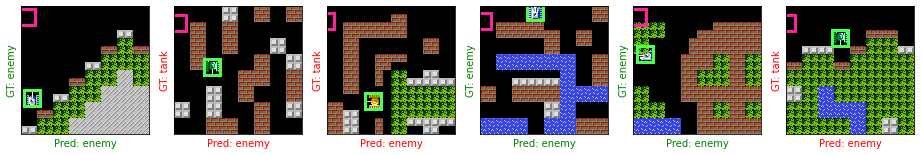

In [20]:
test(model)

In [21]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            test(self.model)

## Task 10: Model Training

In [22]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 30 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

Epoch 1/100
1/1 [==============================] - 0s 28ms/step


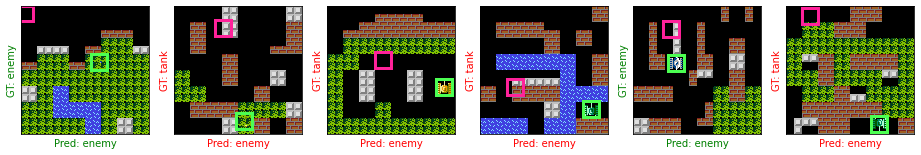

100/100 [==============================] - 32s 287ms/step - loss: 4.0202 - class_out_loss: 0.7644 - box_out_loss: 3.2559 - class_out_accuracy: 0.5469 - box_out_iou: 0.0988
Epoch 2/100
100/100 [==============================] - 29s 289ms/step - loss: 0.7341 - class_out_loss: 0.6632 - box_out_loss: 0.0709 - class_out_accuracy: 0.5967 - box_out_iou: 0.1583
Epoch 3/100
100/100 [==============================] - 29s 295ms/step - loss: 0.5844 - class_out_loss: 0.5203 - box_out_loss: 0.0641 - class_out_accuracy: 0.7227 - box_out_iou: 0.1707
Epoch 4/100
100/100 [==============================] - 29s 286ms/step - loss: 0.4071 - class_out_loss: 0.3465 - box_out_loss: 0.0606 - class_out_accuracy: 0.8461 - box_out_iou: 0.1909
Epoch 5/100
100/100 [==============================] - 28s 285ms/step - loss: 0.2451 - class_out_loss: 0.1895 - box_out_loss: 0.0556 - class_out_accuracy: 0.9320 - box_out_iou: 0.2126
Epoch 6/100
1/1 [==============================] - 0s 54ms/step


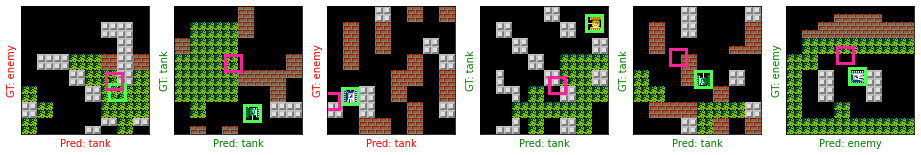

100/100 [==============================] - 29s 287ms/step - loss: 0.1136 - class_out_loss: 0.0701 - box_out_loss: 0.0435 - class_out_accuracy: 0.9762 - box_out_iou: 0.2551
Epoch 7/100
100/100 [==============================] - 29s 286ms/step - loss: 0.0781 - class_out_loss: 0.0409 - box_out_loss: 0.0372 - class_out_accuracy: 0.9848 - box_out_iou: 0.2962
Epoch 8/100
100/100 [==============================] - 28s 283ms/step - loss: 0.0638 - class_out_loss: 0.0277 - box_out_loss: 0.0361 - class_out_accuracy: 0.9902 - box_out_iou: 0.3144
Epoch 9/100
100/100 [==============================] - 28s 285ms/step - loss: 0.0523 - class_out_loss: 0.0187 - box_out_loss: 0.0337 - class_out_accuracy: 0.9936 - box_out_iou: 0.3186
Epoch 10/100
100/100 [==============================] - 29s 286ms/step - loss: 0.0673 - class_out_loss: 0.0326 - box_out_loss: 0.0347 - class_out_accuracy: 0.9889 - box_out_iou: 0.3307
Epoch 11/100
1/1 [==============================] - 0s 75ms/step


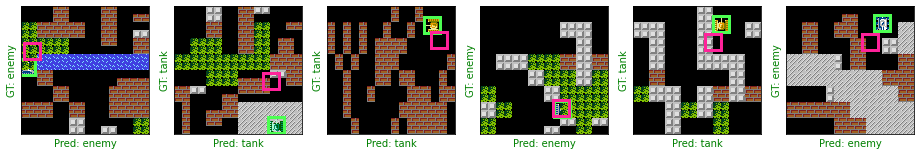

100/100 [==============================] - 35s 346ms/step - loss: 0.0455 - class_out_loss: 0.0153 - box_out_loss: 0.0302 - class_out_accuracy: 0.9952 - box_out_iou: 0.3546
Epoch 12/100
100/100 [==============================] - 32s 315ms/step - loss: 0.0560 - class_out_loss: 0.0224 - box_out_loss: 0.0336 - class_out_accuracy: 0.9923 - box_out_iou: 0.3217
Epoch 13/100
100/100 [==============================] - 29s 288ms/step - loss: 0.0359 - class_out_loss: 0.0103 - box_out_loss: 0.0255 - class_out_accuracy: 0.9964 - box_out_iou: 0.3682
Epoch 14/100
100/100 [==============================] - 34s 345ms/step - loss: 0.0330 - class_out_loss: 0.0114 - box_out_loss: 0.0216 - class_out_accuracy: 0.9973 - box_out_iou: 0.4063
Epoch 15/100
100/100 [==============================] - 30s 301ms/step - loss: 0.0617 - class_out_loss: 0.0344 - box_out_loss: 0.0273 - class_out_accuracy: 0.9892 - box_out_iou: 0.3609
Epoch 16/100
1/1 [==============================] - 0s 44ms/step


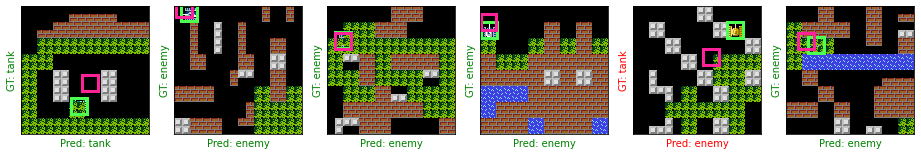

100/100 [==============================] - 29s 288ms/step - loss: 0.0404 - class_out_loss: 0.0142 - box_out_loss: 0.0262 - class_out_accuracy: 0.9959 - box_out_iou: 0.3691
Epoch 17/100
100/100 [==============================] - 31s 315ms/step - loss: 0.0265 - class_out_loss: 0.0073 - box_out_loss: 0.0192 - class_out_accuracy: 0.9967 - box_out_iou: 0.4232
Epoch 18/100
100/100 [==============================] - 40s 401ms/step - loss: 0.0339 - class_out_loss: 0.0132 - box_out_loss: 0.0208 - class_out_accuracy: 0.9962 - box_out_iou: 0.4092
Epoch 19/100
100/100 [==============================] - 29s 287ms/step - loss: 0.0234 - class_out_loss: 0.0076 - box_out_loss: 0.0158 - class_out_accuracy: 0.9975 - box_out_iou: 0.4549
Epoch 20/100
100/100 [==============================] - 30s 299ms/step - loss: 0.0275 - class_out_loss: 0.0072 - box_out_loss: 0.0203 - class_out_accuracy: 0.9972 - box_out_iou: 0.4191
Epoch 21/100
1/1 [==============================] - 0s 56ms/step


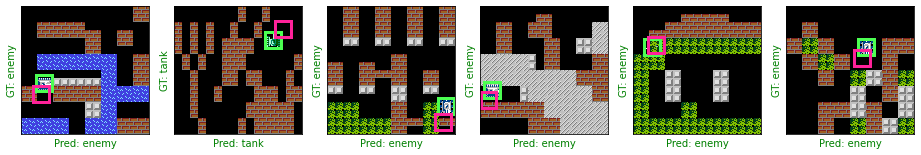

100/100 [==============================] - 35s 348ms/step - loss: 0.0219 - class_out_loss: 0.0075 - box_out_loss: 0.0144 - class_out_accuracy: 0.9984 - box_out_iou: 0.4556
Epoch 22/100
100/100 [==============================] - 37s 371ms/step - loss: 0.0298 - class_out_loss: 0.0135 - box_out_loss: 0.0163 - class_out_accuracy: 0.9962 - box_out_iou: 0.4507
Epoch 23/100
100/100 [==============================] - 28s 284ms/step - loss: 0.0221 - class_out_loss: 0.0070 - box_out_loss: 0.0150 - class_out_accuracy: 0.9973 - box_out_iou: 0.4648
Epoch 24/100
100/100 [==============================] - 31s 311ms/step - loss: 0.0214 - class_out_loss: 0.0077 - box_out_loss: 0.0137 - class_out_accuracy: 0.9978 - box_out_iou: 0.4712
Epoch 25/100
100/100 [==============================] - 43s 436ms/step - loss: 0.0157 - class_out_loss: 0.0037 - box_out_loss: 0.0120 - class_out_accuracy: 0.9984 - box_out_iou: 0.5063
Epoch 26/100
1/1 [==============================] - 0s 59ms/step


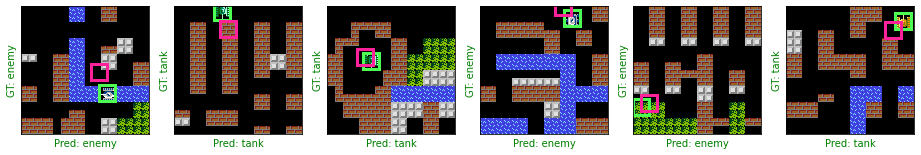

100/100 [==============================] - 46s 463ms/step - loss: 0.0137 - class_out_loss: 0.0033 - box_out_loss: 0.0104 - class_out_accuracy: 0.9989 - box_out_iou: 0.5198
Epoch 27/100
100/100 [==============================] - 43s 431ms/step - loss: 0.0141 - class_out_loss: 0.0045 - box_out_loss: 0.0096 - class_out_accuracy: 0.9986 - box_out_iou: 0.5272
Epoch 28/100
100/100 [==============================] - 40s 403ms/step - loss: 0.0175 - class_out_loss: 0.0061 - box_out_loss: 0.0114 - class_out_accuracy: 0.9977 - box_out_iou: 0.5135
Epoch 29/100
100/100 [==============================] - 29s 293ms/step - loss: 0.0474 - class_out_loss: 0.0259 - box_out_loss: 0.0215 - class_out_accuracy: 0.9922 - box_out_iou: 0.3913
Epoch 30/100
100/100 [==============================] - 31s 313ms/step - loss: 0.0216 - class_out_loss: 0.0078 - box_out_loss: 0.0137 - class_out_accuracy: 0.9983 - box_out_iou: 0.4682
Epoch 31/100
1/1 [==============================] - 0s 77ms/step


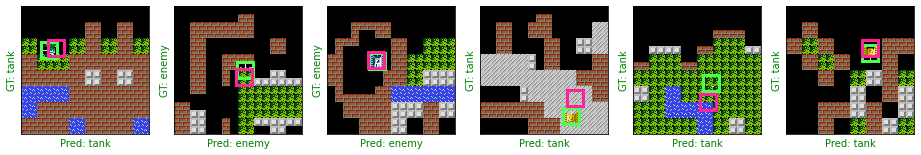

100/100 [==============================] - 31s 312ms/step - loss: 0.0092 - class_out_loss: 0.0013 - box_out_loss: 0.0079 - class_out_accuracy: 0.9995 - box_out_iou: 0.5535
Epoch 32/100
100/100 [==============================] - 30s 298ms/step - loss: 0.0110 - class_out_loss: 0.0030 - box_out_loss: 0.0080 - class_out_accuracy: 0.9991 - box_out_iou: 0.5616
Epoch 33/100
100/100 [==============================] - 38s 381ms/step - loss: 0.0096 - class_out_loss: 0.0026 - box_out_loss: 0.0070 - class_out_accuracy: 0.9994 - box_out_iou: 0.5696
Epoch 34/100
100/100 [==============================] - 29s 292ms/step - loss: 0.0093 - class_out_loss: 0.0022 - box_out_loss: 0.0070 - class_out_accuracy: 0.9992 - box_out_iou: 0.5729
Epoch 35/100
100/100 [==============================] - 34s 339ms/step - loss: 0.0053 - class_out_loss: 6.8095e-04 - box_out_loss: 0.0046 - class_out_accuracy: 0.9998 - box_out_iou: 0.6236
Epoch 36/100
1/1 [==============================] - 0s 54ms/step


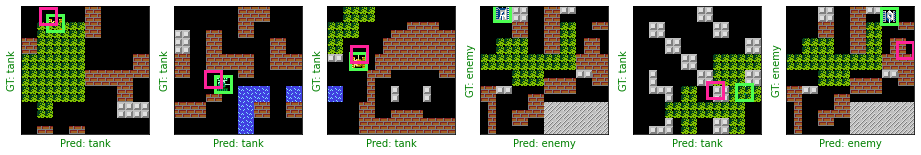

100/100 [==============================] - 44s 441ms/step - loss: 0.0265 - class_out_loss: 0.0158 - box_out_loss: 0.0107 - class_out_accuracy: 0.9950 - box_out_iou: 0.5167
Epoch 37/100
100/100 [==============================] - 41s 415ms/step - loss: 0.0317 - class_out_loss: 0.0169 - box_out_loss: 0.0148 - class_out_accuracy: 0.9945 - box_out_iou: 0.4607
Epoch 38/100
100/100 [==============================] - 41s 411ms/step - loss: 0.0272 - class_out_loss: 0.0145 - box_out_loss: 0.0127 - class_out_accuracy: 0.9958 - box_out_iou: 0.4802
Epoch 39/100
100/100 [==============================] - 42s 416ms/step - loss: 0.0151 - class_out_loss: 0.0071 - box_out_loss: 0.0081 - class_out_accuracy: 0.9975 - box_out_iou: 0.5437
Epoch 40/100
100/100 [==============================] - 41s 415ms/step - loss: 0.0132 - class_out_loss: 0.0049 - box_out_loss: 0.0083 - class_out_accuracy: 0.9983 - box_out_iou: 0.5416
Epoch 41/100
1/1 [==============================] - 0s 47ms/step


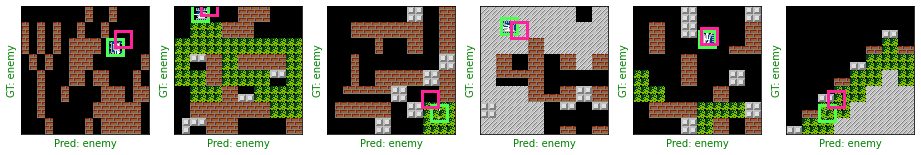

100/100 [==============================] - 45s 448ms/step - loss: 0.0143 - class_out_loss: 0.0066 - box_out_loss: 0.0078 - class_out_accuracy: 0.9980 - box_out_iou: 0.5540
Epoch 42/100
100/100 [==============================] - 31s 305ms/step - loss: 0.0146 - class_out_loss: 0.0067 - box_out_loss: 0.0079 - class_out_accuracy: 0.9984 - box_out_iou: 0.5561
Epoch 43/100
100/100 [==============================] - 29s 285ms/step - loss: 0.0114 - class_out_loss: 0.0047 - box_out_loss: 0.0066 - class_out_accuracy: 0.9986 - box_out_iou: 0.5725
Epoch 44/100
100/100 [==============================] - 29s 291ms/step - loss: 0.0104 - class_out_loss: 0.0037 - box_out_loss: 0.0067 - class_out_accuracy: 0.9987 - box_out_iou: 0.5854
Epoch 45/100
100/100 [==============================] - 29s 291ms/step - loss: 0.0093 - class_out_loss: 0.0029 - box_out_loss: 0.0063 - class_out_accuracy: 0.9995 - box_out_iou: 0.5869


In [23]:
history = model.fit(
    data_generator(),
    epochs=100,
    steps_per_epoch=100,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=10, mode='max'),
        #tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

In [24]:
history.history

{'loss': [4.020236968994141,
  0.7340914011001587,
  0.5843688249588013,
  0.40707898139953613,
  0.24507012963294983,
  0.11362500488758087,
  0.07810340076684952,
  0.06376773118972778,
  0.05234578624367714,
  0.06729846447706223,
  0.04548239707946777,
  0.056044187396764755,
  0.035883449018001556,
  0.03298709914088249,
  0.06166345626115799,
  0.0403558649122715,
  0.026548897847533226,
  0.03391888737678528,
  0.023403530940413475,
  0.027522092685103416,
  0.021899938583374023,
  0.02979048527777195,
  0.022058377042412758,
  0.021409595385193825,
  0.01570984348654747,
  0.01374811865389347,
  0.014069139026105404,
  0.017456375062465668,
  0.04740942642092705,
  0.02159387804567814,
  0.009207244962453842,
  0.011029338464140892,
  0.009592373855412006,
  0.00926894135773182,
  0.005316243972629309,
  0.026489242911338806,
  0.031665533781051636,
  0.027229588478803635,
  0.015124664641916752,
  0.013191211968660355,
  0.014323758892714977,
  0.01462000235915184,
  0.0113723

In [25]:
error

NameError: name 'error' is not defined

In [26]:
model.save_weights("model_100_100_fixed_lr.h5")